In [9]:
'''This script is a part of airbnb lisitng prediction'''
   
__author__ = 'Sandeep Kumar Kola'
__email__ = 'sandeep.kola07@gmail.com'

In [10]:
# Import required packages.
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from keras.layers import Dense
import warnings
warnings.filterwarnings('ignore')

In [25]:
class Model:
    def _init_(self, path):
        self.path = path
    
    def _load_data(path):
        dataset = pd.read_csv(path)
        print("-- Taking the important dependant variables only-- ")
        cleaned_dataset = pd.DataFrame(dataset, columns = ['price',
           'room_type',
           'neighbourhood_cleansed',
           'accommodates',
           'bathrooms',
           'bedrooms',
           'beds',
           'review_scores_rating',
           'instant_bookable',
           'cancellation_policy',
           'amenities'])
        return cleaned_dataset
    
    def _check_nulls(data):
        return data.isnull().sum()
        
    def _quantile(cleaned_dataset, upper=75, lower=25, k=3):
        # Remove unwanted characters.
        cleaned_dataset['price'] = cleaned_dataset['price'].replace({'\$': '', 
                       '\,': ''}, regex=True).astype(float)
        iqr = np.subtract(*np.percentile(cleaned_dataset['price'],
                                         [upper, lower]))
        
        upper_fence = np.percentile(cleaned_dataset['price'], upper) + k*iqr
        lower_fence = np.percentile(cleaned_dataset['price'], lower) + k*iqr
        print(" -- Upper and lower fences are: " + str(upper_fence) + ", " + 
              str(lower_fence))
        
    def _exploratory_analysis(cleaned_dataset):
        
        print("-- Building histogram for price variable --")
        plt.hist(cleaned_dataset['price'], facecolor='blue', normed=True, 
                 bins=1000)
        plt.xscale('log')
        plt.show()
        
        print("-- Building boxplot for price variable --")
        plt.boxplot(cleaned_dataset['price'])
        plt.show()
                
        print("-- Removing rows with price gretaer than 4000")
        cleaned_dataset = cleaned_dataset[cleaned_dataset.price <= 4000]
        
        mean = round(np.mean(cleaned_dataset['price']), 2)
        cleaned_dataset['price'] = cleaned_dataset['price'].fillna(mean)

        print("-- Imputing missing bedrooms by median --")
        bedroom_med = cleaned_dataset['bedrooms'].median()
        cleaned_dataset['bedrooms'] = cleaned_dataset['bedrooms'].fillna(bedroom_med)
       
        print("-- Imputing missing beds by median --")
        bed_med = cleaned_dataset['beds'].median()
        cleaned_dataset['beds'] = cleaned_dataset['beds'].fillna(bed_med)
        
        print("-- Imputing missing review_scores_rating by mean --")
        cleaned_dataset['review_scores_rating'].describe()
        rv_mean = cleaned_dataset['review_scores_rating'].mean()
        cleaned_dataset['review_scores_rating'] = \
                    cleaned_dataset['review_scores_rating'].fillna(rv_mean)
                    
        print("-- Imputing missing beds by median --")
        acc_med = cleaned_dataset['accommodates'].median()
        cleaned_dataset['accommodates'] =  \
                    cleaned_dataset['accommodates'].fillna(acc_med)
        
        print("-- Imputing missing bathrooms by median --")
        bath_med = cleaned_dataset['bathrooms'].median()
        cleaned_dataset['bathrooms'] = \
                    cleaned_dataset['bathrooms'].fillna(bath_med)
        return cleaned_dataset, plot_hist, plot_box

  
    def _clean_data(cleaned_dataset):
        print("-- Checking for null values --")
        cleaned_dataset.apply(lambda x: np.all(x==0))
        print('''-- Check for negative values --''')

        before_clean = len(cleaned_dataset)
        cleaned_dataset = cleaned_dataset[cleaned_dataset.price >= 0]
        cleaned_dataset = cleaned_dataset[cleaned_dataset.bedrooms >= 0]
        cleaned_dataset = cleaned_dataset[cleaned_dataset.beds >= 0]
        cleaned_dataset = \
                cleaned_dataset[cleaned_dataset.review_scores_rating >= 0]
        cleaned_dataset = cleaned_dataset[cleaned_dataset.accommodates >= 0]
        cleaned_dataset = cleaned_dataset[cleaned_dataset.bathrooms >= 0]
        after_clean = len(cleaned_dataset)
        
        records_rem = before_clean - after_clean
        
        print("-- No of records removed: " + str(records_rem) + " --")
        
        return cleaned_dataset

    def _save_data(cleaned_dataset):
        cleaned_dataset.to_csv('data.csv', index=True) 
    
    def _data_preprocessing(cleaned_dataset):
        print('''-- Variables room_type, cancellation_policy, 
        neighbourhood_cleansed, instant_bookable are all categorical.''')
        
        print("-- Converting amenities to values --")
        number_amenities = []

        for am in cleaned_dataset.amenities:
            am = am[1:]
            am = am[:-1]
            x = am.split()
            number_amenities.append(len(x))
        
        # Appending the amenities to the dataframe.
        cleaned_dataset.amenities = number_amenities
        
        print("-- Splitting dependant and independant variables --")
        X = cleaned_dataset.iloc[:, 1:10].values
        y = cleaned_dataset.iloc[:, 0].values
        
        # Enconding categorical variables.
        # instant_bookable t, f no dummy variable trap.
        labelencoder_X_1 = LabelEncoder()
        X[:, 7] = labelencoder_X_1.fit_transform(X[:, 7])   
        # room_type yes dummy variable trap
        labelencoder_X_2 = LabelEncoder()
        X[:, 0] = labelencoder_X_2.fit_transform(X[:, 0])      
        # cancellation policy no dummy variable trap.
        labelencoder_X_3 = LabelEncoder()
        X[:, 8] = labelencoder_X_3.fit_transform(X[:, 8])        
        # neighbourhood yes dummy variable trap
        labelencoder_X_4 = LabelEncoder()
        X[:, 1] = labelencoder_X_4.fit_transform(X[:, 1])
        
        # removing dummy variables after encoding.
        # room_type dummy 
        onehotencoder = OneHotEncoder(categorical_features = [0])
        X = onehotencoder.fit_transform(X).toarray()
        X = X[:, 1:]
        # Cancelleation plociy.
        onehotencoder_1 = OneHotEncoder(categorical_features = [9])
        X = onehotencoder_1.fit_transform(X).toarray()
        X = X[:, 1:]   
        # neighbourhood plociy.
        onehotencoder_2 = OneHotEncoder(categorical_features = [5])
        X = onehotencoder_2.fit_transform(X).toarray()
        X = X[:, 1:]
        
        X_train, X_test, y_train, y_test = \
                    train_test_split(X, y, test_size = 0.2, random_state = 0)
        
        print("-- Feature scaling the train and test data --")
        # Train
        sc = StandardScaler()
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
        
        # Test
        # Convert the array to 2D
        y_train = y_train.reshape(-1, 1)
        y_test = y_test.reshape(-1, 1)
        sc_test = StandardScaler()
        y_train = sc_test.fit_transform(y_train)
        y_test = sc_test.transform(y_test)
        
        return X_train, X_test, y_train, y_test, sc_test

    def _ANN_(X_train, y_train, batch_size = 10, epochs = 50):
        # Initialising the ANN
        classifier = Sequential()
    
        # Adding the input layer and the first hidden layer
        classifier.add(Dense(units = 20, kernel_initializer = 'uniform', 
                             activation = 'relu', input_dim = 40))
        
        # Adding the second hidden layer
        classifier.add(Dense(units = 20, kernel_initializer = 'uniform', 
                             activation = 'relu'))
        
        # Adding the output layer
        classifier.add(Dense(units = 1, kernel_initializer = 'uniform'))
        
        # Compiling the ANN
        classifier.compile(optimizer = 'adam', loss = 'mean_squared_error',
                           metrics = ['mae'])
        
        
        # Fitting the ANN to the Training set
        classifier.fit(X_train, y_train, batch_size = 10, epochs = 50)
        
        return classifier
    
    def _predict(X_test, classifier):
        y_pred = classifier.predict(X_test)
        return y_pred

    def _plot_results(y_pred, y_test, sc_test):
        y_pred = sc_test.inverse_transform(y_pred)
        y_test = sc_test.inverse_transform(y_test)
        #Plotting the results.
        plt.scatter(np.arange(len(y_pred)),y_pred, color = 'blue')
        plt.scatter(np.arange(len(y_pred)), y_test, color = 'red')
        plt.show()

In [26]:
if __name__ == '__main__':
    # Path name.
    path = "/Users/sandeepkola/Desktop/Kaggle/Project 3 Quantify/Quantiy copy/listings.csv"
    cleaned_dataset = Model._load_data(path)
    # Check for nulls.
    Model._check_nulls(cleaned_dataset) 
    # Quantiles
    Model._quantile(cleaned_dataset, upper=75, lower=25, k=3)

-- Taking the important dependant variables only-- 
 -- Upper and lower fences are: 460.0, 362.0


-- Building histogram for price variable --


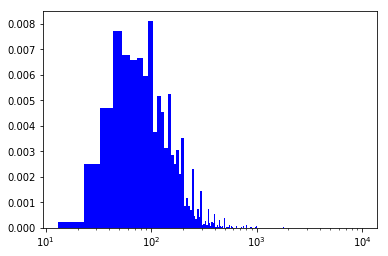

-- Building boxplot for price variable --


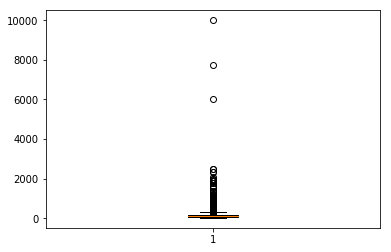

-- Removing rows with price gretaer than 4000
-- Imputing missing bedrooms by median --
-- Imputing missing beds by median --
-- Imputing missing review_scores_rating by mean --
-- Imputing missing beds by median --
-- Imputing missing bathrooms by median --


In [27]:
# Exploratory data analysis.
cleaned_dataset, plot_hist,  plot_box = Model._exploratory_analysis(cleaned_dataset)

In [28]:
# Clean the data.
cleaned_dataset = Model._clean_data(cleaned_dataset)

-- Checking for null values --
-- Check for negative values --
-- No of records removed: 0 --


In [29]:
# Save the data.
Model._save_data(cleaned_dataset)

In [30]:
# Make train and test data.
X_train, X_test, y_train, y_test, sc_test = Model._data_preprocessing(cleaned_dataset)

-- Variables room_type, cancellation_policy, 
        neighbourhood_cleansed, instant_bookable are all categorical.
 
 -- Converting amenities to values --
-- Splitting dependant and independant variables --
-- Feature scaling the train and test data --


In [31]:
# Build the ANN classifier.
classifier = Model._ANN_(X_train, y_train, batch_size = 10, epochs = 100)

Epoch 1/50
11441/11441 [==============================] - 1s - loss: 0.6007 - mean_absolute_error: 0.3644     
Epoch 2/50
11441/11441 [==============================] - 0s - loss: 0.5345 - mean_absolute_error: 0.3391     
Epoch 3/50
11441/11441 [==============================] - 1s - loss: 0.5226 - mean_absolute_error: 0.3322     
Epoch 4/50
11441/11441 [==============================] - 1s - loss: 0.5136 - mean_absolute_error: 0.3302     
Epoch 5/50
11441/11441 [==============================] - 0s - loss: 0.5067 - mean_absolute_error: 0.3297     
Epoch 6/50
11441/11441 [==============================] - 1s - loss: 0.5014 - mean_absolute_error: 0.3280     - ETA: 0s - loss: 0.5903 - mean_absolute
Epoch 7/50
11441/11441 [==============================] - 1s - loss: 0.4976 - mean_absolute_error: 0.3269     
Epoch 8/50
11441/11441 [==============================] - 1s - loss: 0.4939 - mean_absolute_error: 0.3263     - ETA: 0s - loss: 0.6682 - mean_absolu
Epoch 9/50
11441/11441 [==========

In [32]:
# Make the predictions.
y_pred =   Model._predict(X_test, classifier)

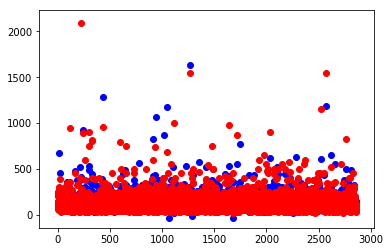

In [33]:
# Plot the results.
Model._plot_results(y_pred, y_test, sc_test)           